### DPCN Team Baby Sharks Project
- Amey Choudhary
- Aryan Gupta
- Keshav Gupta

# EWT

In [40]:
# Modular code from here

# Flow of the pipeline
# 1. Read the data
# 2. Perform Signal Decomposition
# 3. Train the models
# 4. Forecast the results

In [41]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as  nn
import torch.optim as optim
import torch

In [42]:
# Selecting the dataset. Change the file path and type of data
file_path ="./Datasets/Malaria_datasets/Venezuela_Malaria.xlsx"

# Reading the data
dataset = pd.read_excel(file_path)

print("The shape of the dataset: ", dataset.shape)
print("The first 5 entries are:" )
print(dataset.head())


The shape of the dataset:  (669, 2)
The first 5 entries are:
   Weeks  Cases
0      1    588
1      2    635
2      3    405
3      4    425
4      5    452


In [43]:
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]

# selecting the hyperparameters for the dataset from excel
hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

# finding the hyperparameters for the dataset
for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

# type of dataset as in weekly or monthly. need to set this manually after looking at the dataset values
type_of_dataset = "Weekly" # "Weekly" or "Monthly

# select the index of time
index_of_cases = 1

# select the forecast type manually
forecast_type = "Medium" # "Short" or "Medium" or "Long"

p = hyperparameters[forecast_type][hyperparameters_index]
k = (p+1)//2

pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

if type_of_dataset == "Weekly":
    pred_length = pred_length_weekly[forecast_type]
else:
    pred_length = pred_length_monthly[forecast_type]

test_size = pred_length
valid_size = 2*pred_length
train_size = dataset.shape[0] - test_size - valid_size-p # p is the lag, so train size wont contain the first p values

print("The value of p:",p)
print("The value of k:", k)
print("The prediction length is:", pred_length)



The value of p: 12
The value of k: 6
The prediction length is: 26


The length of the time series data is:  669


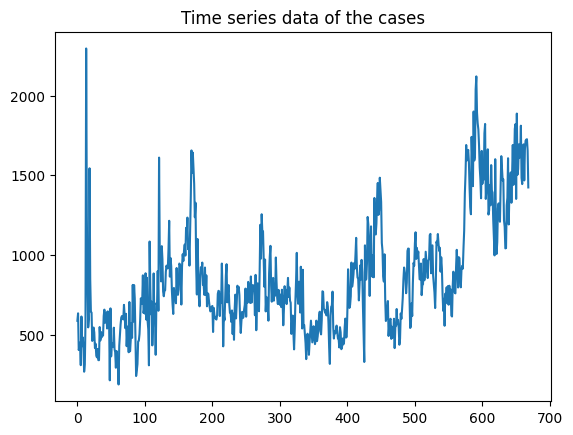

In [44]:
# changing to time series data
cases_time_series = dataset.iloc[:, index_of_cases].values
print("The length of the time series data is: ", len(cases_time_series))
plt.plot(cases_time_series)
plt.title("Time series data of the cases")
plt.show()

In [45]:
cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

# scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)


In [46]:
!pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable


In [47]:
import numpy as np

def EWT1D(f, N = 5, log = 0,detect = "locmax", completion = 0, reg = 'average', lengthFilter = 10,sigmaFilter = 5):
    #signal spectrum
    ff = np.fft.fft(f)
    ff = abs(ff[0:ff.size//2]) #one-sided magnitude

    #extract boundaries of Fourier Segments
    boundaries = EWT_Boundaries_Detect(ff,log,detect,N,reg,lengthFilter,sigmaFilter)
    boundaries = boundaries*np.pi/round(ff.size)
    
    if completion == 1 and len(boundaries)<N-1:
        boundaries = EWT_Boundaries_Completion(boundaries,N-1) 

    #Filtering
    #extend the signal by mirroring to deal with boundaries
    ltemp = f.size//2 #to behave the same as matlab's round
    fMirr =  np.append(np.flip(f[0:ltemp-1],axis = 0), f)  
    fMirr = np.append(fMirr, np.flip(f[-ltemp-1:-1], axis = 0))
    ffMirr = np.fft.fft(fMirr)
    
    #build the corresponding filter bank
    mfb = EWT_Meyer_FilterBank(boundaries, ffMirr.size)
    
    #filter the signal to extract each subband
    ewt = np.zeros(mfb.shape)
    for k in range(mfb.shape[1]):
        ewt[:,k] = np.real(np.fft.ifft(np.conjugate(mfb[:,k])*ffMirr))
    ewt = ewt[ltemp-1:-ltemp,:]
    
    return ewt

def EWT_Boundaries_Detect(ff,log,detect, N, reg, lengthFilter,sigmaFilter):
    from scipy.ndimage.filters import gaussian_filter
    #apply log if needed
    if log == 1:
        ff = np.log(ff)
    
    #Global trend removal - TODO
    
    #Regularization 
    if reg == 'average':
        regFilter = np.ones(lengthFilter)/lengthFilter 
        presig = np.convolve(ff,regFilter,mode = 'same') # for even length, numpy's convolve is shifted when compared with MATLAB's
    elif reg == 'gaussian':
        regFilter = np.zeros(lengthFilter)
        regFilter[regFilter.size//2] = 1 # prefer odd filter lengths - otherwise the gaussian is skewed
        presig = np.convolve(ff,gaussian_filter(regFilter,sigmaFilter),mode = 'same') 
    else:
        presig = ff

    #Boundaries detection
    if detect  == "locmax":#Mid-point between two consecutive local maxima computed on the regularized spectrum
        boundaries = LocalMax(presig,N)
        
    elif detect == "locmaxmin":#extract the lowest local minima between two selected local maxima
        boundaries =  LocalMaxMin(presig,N)
        
    elif detect == "locmaxminf":#We extract the lowest local minima on the original spectrum between 
                                #two local maxima selected on the regularized signal
        boundaries =  LocalMaxMin(presig,N,fm = ff)
    
    return boundaries+1

        
def LocalMax(ff, N):
    N=N-1
    locmax = np.zeros(ff.size)
    locmin = max(ff)*np.ones(ff.size)
    for i in np.arange(1,ff.size-1):
        if ff[i-1]<ff[i] and ff[i]>ff[i+1]:
            locmax[i] = ff[i]
        if ff[i-1]> ff[i] and ff[i] <= ff[i+1]:
            locmin[i] = ff[i]
    N = min(N,locmax.size) 
    #keep the N-th highest maxima
    maxidxs = np.sort(locmax.argsort()[::-1][:N])
    #middle point between consecutive maxima
    bound = np.zeros(N)
    for i in range(N):
        if i == 0:
            a = 0
        else:
            a = maxidxs[i-1]
        bound[i] = (a + maxidxs[i])/2
        
    return bound

def LocalMaxMin(f,N,fm = 0):

    locmax= np.zeros(f.size)  
    if type(fm) == int: 
        f2 = f
    else:
        f2 = fm
    locmin = max(f2)*np.ones(f2.size)
    #detect local minima and maxima
    for i in np.arange(1,f.size-1):
        if ((f[i-1]<f[i]) and (f[i]>f[i+1])):
            locmax[i] = f[i]
        if ((f2[i-1]>f2[i]) and (f2[i]<f2[i+1])):
            locmin[i] = f2[i]
    #keep the N-th highest maxima and their index
    if N!=-1:
        N = N-1
        #keep the N-th highest maxima
        Imax = np.sort(locmax.argsort()[::-1][:N])
        #detect the lowest minima between two consecutive maxima
        bound = np.zeros(N)
        for i in range(N):
            if i == 0:
                a = 1
            else:
                a = Imax[i-1]
            lmin = np.sort(locmin[a:Imax[i]])
            ind = np.argsort(locmin[a:Imax[i]])
            tmpp = lmin[0]
            n = 0
            if n < len(lmin):
                n = 1
                while ((n<len(lmin)) and (tmpp==lmin[n])):
                    n = n+1
            bound[i] = a + ind[n//2]-1
    else:
        k = 0
        for i in range(locmin):
            if locmin[i]<max(f2):
                bound[k] = i-1
                k = k+1
    return bound
        

def EWT_Boundaries_Completion(boundaries,NT):
    Nd=NT-len(boundaries)
    deltaw=(np.pi-boundaries[-1])/(Nd+1)
    for k in range(Nd):
        boundaries = np.append(boundaries,boundaries[-1]+deltaw)

def EWT_Meyer_FilterBank(boundaries,Nsig):
    Npic = len(boundaries)
    #compute gamma
    gamma = 1
    for k in range(Npic-1):
        r = (boundaries[k+1]-boundaries[k])/ (boundaries[k+1]+boundaries[k])
        if r < gamma:
            gamma = r
    r = (np.pi - boundaries[Npic-1])/(np.pi + boundaries[Npic-1])
    if r <gamma:
        gamma = r
    gamma = (1-1/Nsig)*gamma#this ensure that gamma is chosen as strictly less than the min

    
    mfb = np.zeros([Nsig,Npic+1])

    #EWT_Meyer_Scaling
    Mi=int(np.floor(Nsig/2))
    w=np.fft.fftshift(np.linspace(0,2*np.pi - 2*np.pi/Nsig,num = Nsig))
    w[0:Mi]=-2*np.pi+w[0:Mi]
    aw=abs(w)
    yms=np.zeros(Nsig)
    an=1./(2*gamma*boundaries[0])
    pbn=(1.+gamma)*boundaries[0]
    mbn=(1.-gamma)*boundaries[0]
    for k in range(Nsig):
       if aw[k]<=mbn:
           yms[k]=1
       elif ((aw[k]>=mbn) and (aw[k]<=pbn)):
           yms[k]=np.cos(np.pi*EWT_beta(an*(aw[k]-mbn))/2)
    yms=np.fft.ifftshift(yms) 
    mfb[:,0] = yms
    
    #generate rest of the wavelets
    for k in range(Npic-1):
        mfb[:,k+1] = EWT_Meyer_Wavelet(boundaries[k],boundaries[k+1],gamma,Nsig)

    mfb[:,Npic] = EWT_Meyer_Wavelet(boundaries[Npic-1],np.pi,gamma,Nsig)
    
    return mfb


def EWT_beta(x):
    if x<0:
        bm=0
    elif x>1:
        bm=1
    else:
        bm=(x**4)*(35.-84.*x+70.*(x**2)-20.*(x**3))
    return bm

def EWT_Meyer_Wavelet(wn,wm,gamma,Nsig):

    Mi=int(np.floor(Nsig/2))
    w=np.fft.fftshift(np.linspace(0,2*np.pi - 2*np.pi/Nsig,num = Nsig))
    w[0:Mi]=-2*np.pi+w[0:Mi]
    aw=abs(w)
    ymw=np.zeros(Nsig)
    an=1./(2*gamma*wn)
    am=1./(2*gamma*wm)
    pbn=(1.+gamma)*wn
    mbn=(1.-gamma)*wn
    pbm=(1.+gamma)*wm
    mbm=(1.-gamma)*wm

    for k in range(Nsig):
       if ((aw[k]>=pbn) and (aw[k]<=mbm)):
           ymw[k]=1
       elif ((aw[k]>=mbm) and (aw[k]<=pbm)):
           ymw[k]=np.cos(np.pi*EWT_beta(am*(aw[k]-mbm))/2)
       elif ((aw[k]>=mbn) and (aw[k]<=pbn)):
           ymw[k]=np.sin(np.pi*EWT_beta(an*(aw[k]-mbn))/2)

    ymw=np.fft.ifftshift(ymw)
    return ymw

In [48]:
# performing signal decomposition

# Perform the wavelet decomposition using PyWavelets
import pywt

# IMFs = pywt.wavedec(cases_time_series_scaled, wavelet='db4', level=4)

imfs_num = np.floor(np.log(len(cases_time_series_scaled)))

IMFs = EWT1D(cases_time_series_scaled)
IMFs = IMFs.T

n_imfs = len(IMFs)
print(n_imfs)




5


/tmp/ipykernel_1352/1325246325.py:34: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


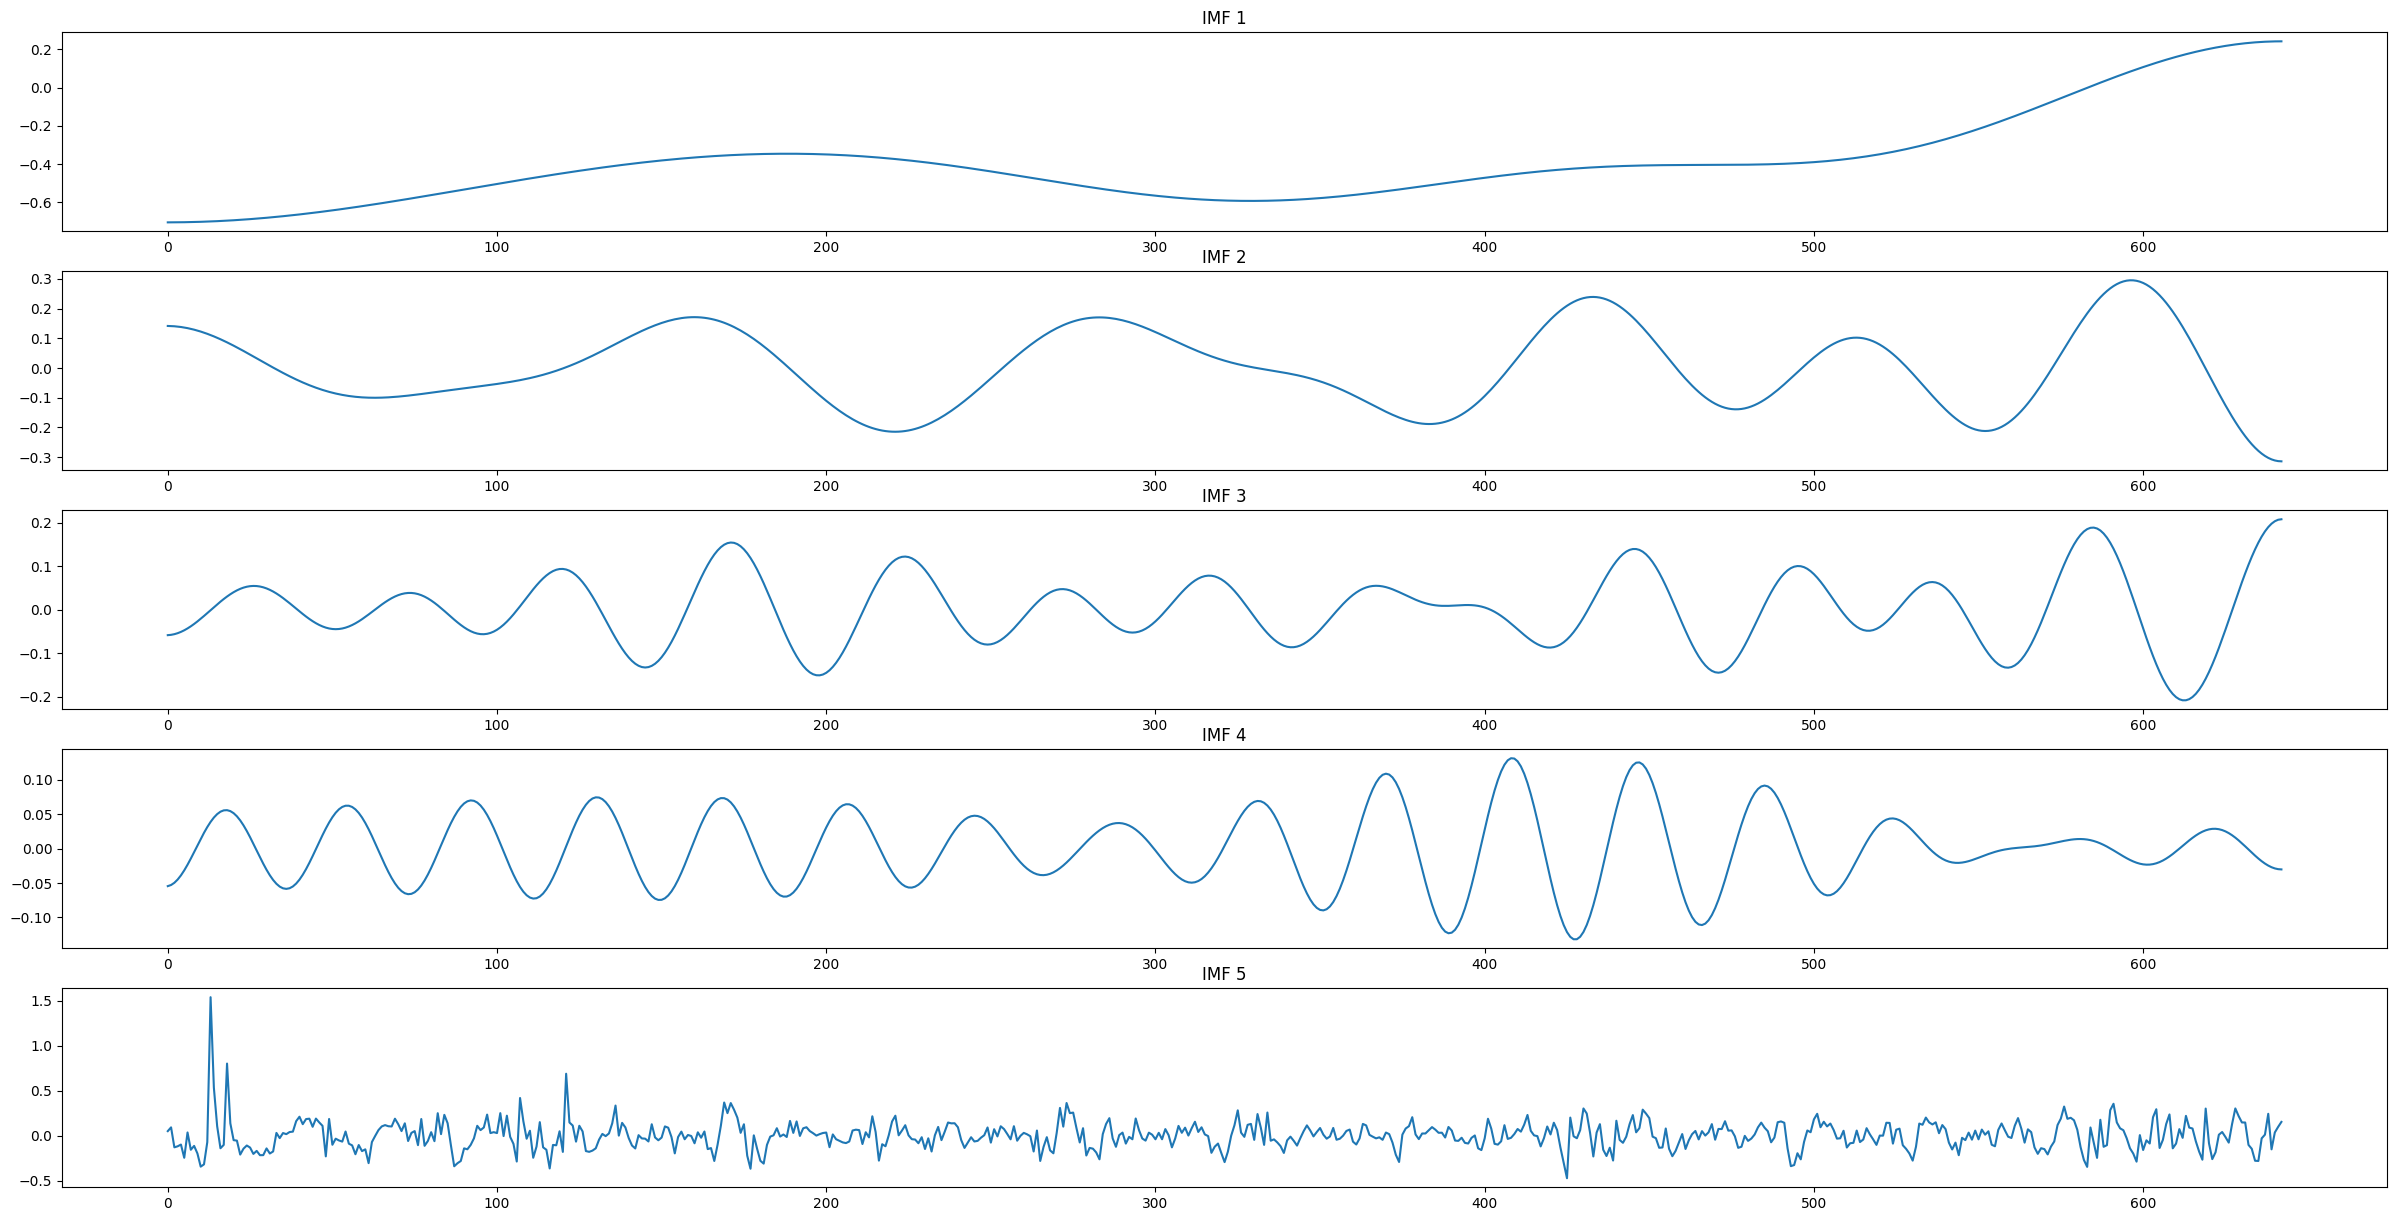

In [49]:
# plotting the IMFs
plt.figure(figsize=(30, 15))
for i in range(n_imfs):
    plt.subplot(n_imfs, 1, i+1)
    plt.plot(IMFs[i])
    plt.title("IMF "+str(i+1))
plt.show()


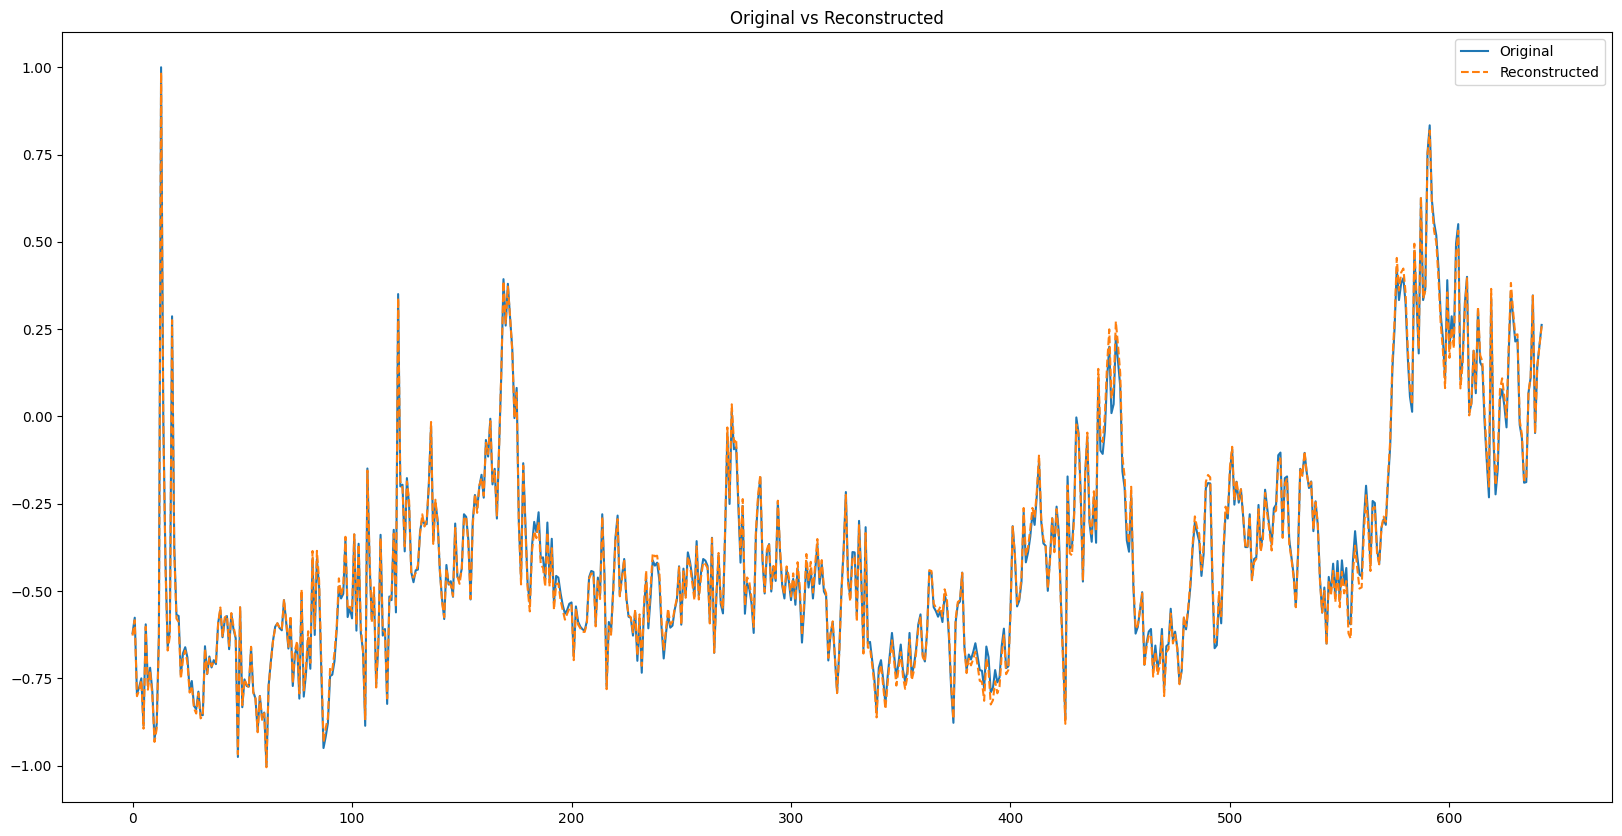

In [50]:
# checking the IMFs and actual
# reconstructed_time_series = pywt.waverec(IMFs, wavelet='db4')
reconstructed_time_series = np.sum(IMFs, axis=0)
plt.figure(figsize=(20, 10))
plt.plot(cases_time_series_scaled, label="Original" )
plt.plot(reconstructed_time_series, label="Reconstructed", linestyle="--")
plt.title("Original vs Reconstructed")
plt.legend()
plt.show()

clearly the decomposition is done well

In [51]:
# creating the class for neural network
class EWNet(nn.Module):
    def __init__(self, p, k):
        super(EWNet, self).__init__()
        self.fc1 = nn.Linear(p, k)
        self.fc2 = nn.Linear(k, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


In [52]:
# creating the train dataset and test dataset

# Define function to create lagged sequences
def create_lagged_sequence(data, lag):
    X, y = [], []
    for i in range(len(data)-lag):
        X.append(data[i:(i+lag)])
        y.append(data[i+lag])
    return np.array(X), np.array(y)



X_train = []
y_train = []
X_valid = []
y_valid = []


for i in range(n_imfs):
    X, y = create_lagged_sequence(IMFs[i], p)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    # as sizes of each sequence different, train size will 80% of total
    # factor = 0.9/
    # train_size = int(factor* len(y))
    # valid_size = int(len(y) - train_size)
    X_train.append(X[0:train_size])
    y_train.append(y[0:train_size])
    X_valid.append(X[train_size:train_size+valid_size])
    y_valid.append(y[train_size:train_size+valid_size])



In [53]:
print("The shape of X_train[0]:", X_train[0].shape)
print("The shape of y_train[0]:", y_train[0].shape)
print("The shape of X_valid[0]:", X_valid[0].shape)
print("The shape of y_valid[0]:", y_valid[0].shape)

The shape of X_train[0]: torch.Size([579, 12])
The shape of y_train[0]: torch.Size([579])
The shape of X_valid[0]: torch.Size([52, 12])
The shape of y_valid[0]: torch.Size([52])


Training started for model:  1
Epoch:  0 Training Loss:  0.35480380058288574 Validation Loss:  0.014876995235681534
Epoch:  1000 Training Loss:  0.0037774282973259687 Validation Loss:  0.050045352429151535
Epoch:  2000 Training Loss:  0.0006479949224740267 Validation Loss:  0.0003633902233559638
Epoch:  3000 Training Loss:  0.00020178465638309717 Validation Loss:  0.0042071035131812096
Epoch:  4000 Training Loss:  0.00015004070883151144 Validation Loss:  0.003475083503872156
Epoch:  5000 Training Loss:  0.00011944168363697827 Validation Loss:  0.001979975961148739
Epoch:  6000 Training Loss:  9.322721598437056e-05 Validation Loss:  0.0010001658229157329
Epoch:  7000 Training Loss:  6.31551883998327e-05 Validation Loss:  0.00036223867209628224
Epoch:  8000 Training Loss:  2.9583205105154775e-05 Validation Loss:  3.4222892281832173e-05
Epoch:  9000 Training Loss:  7.21373908163514e-06 Validation Loss:  5.2684485126519576e-05
Training completed for model:  1
Training started for model:  2

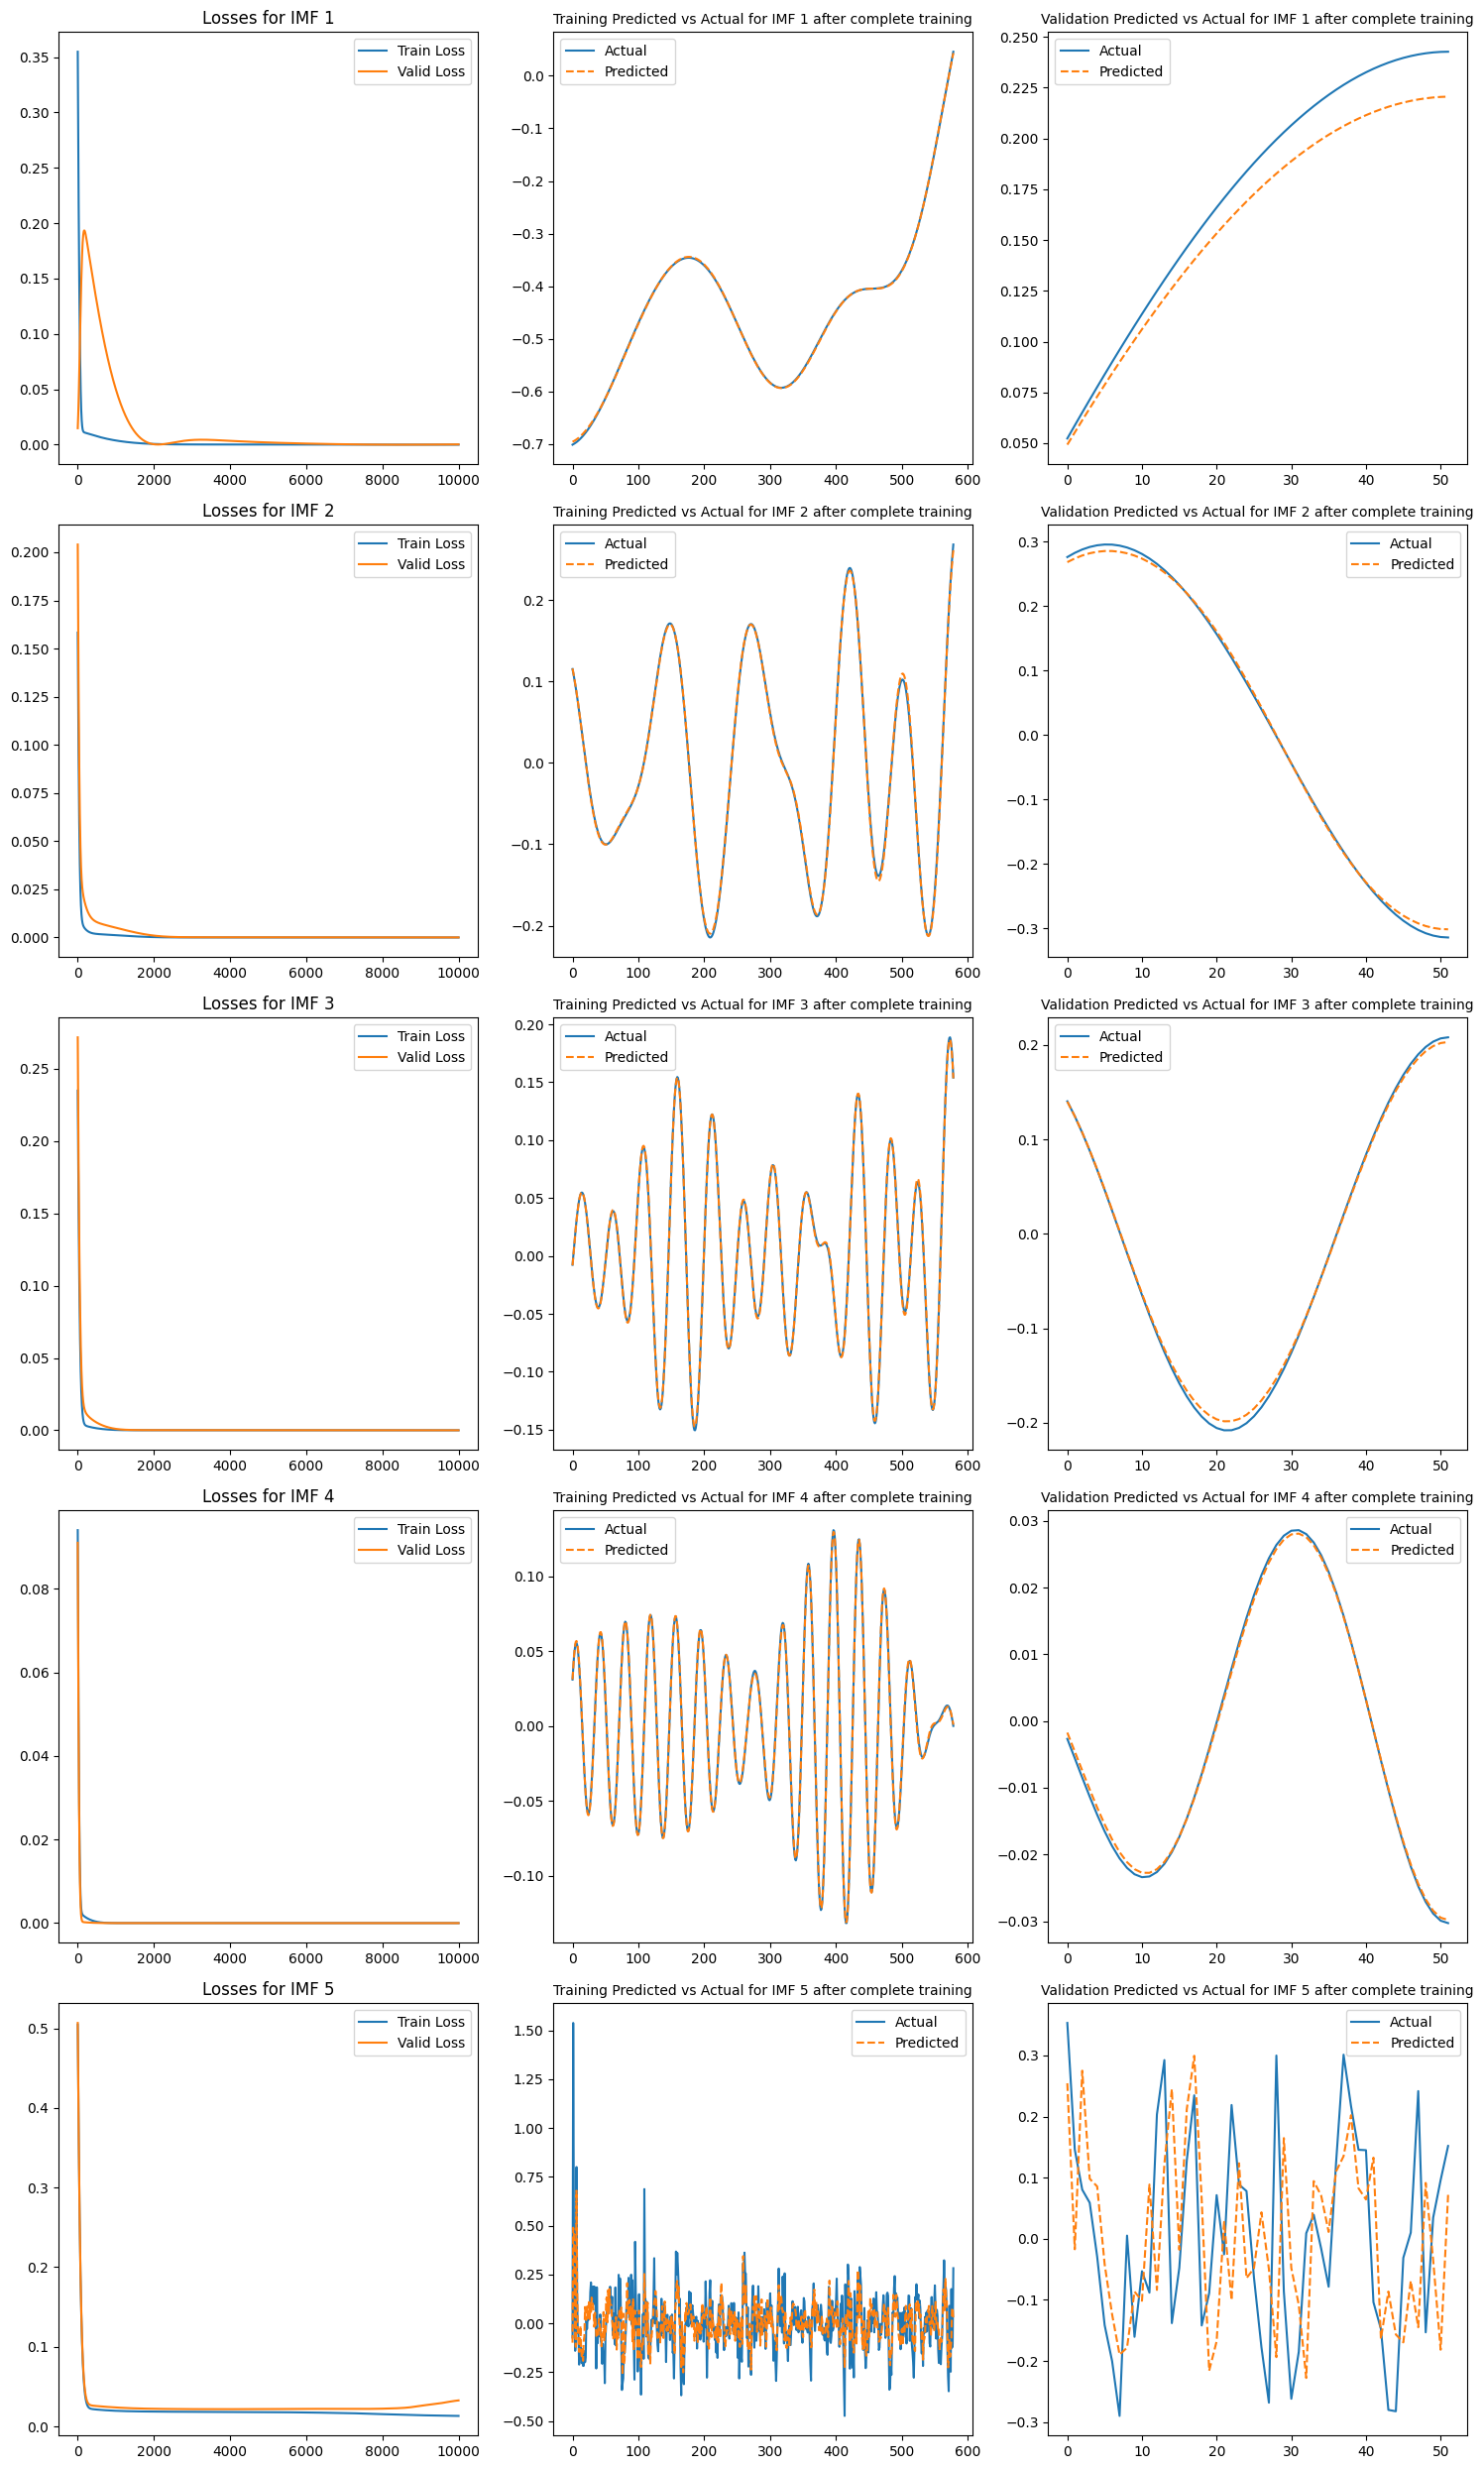

In [54]:
# running the model
n_models = []

fig, axes = plt.subplots(n_imfs, 3, figsize=(15, 5*n_imfs))

for i in range(n_imfs):

    # initializing the model
    model = EWNet(p, k)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10000
    print_freq = 10
    epoch_freq = epochs//print_freq
    train_losses = []
    valid_losses = []

    print("Training started for model: ", i+1)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_train_pred = model(X_train[i])
        y_train_pred = y_train_pred.view(-1)
        loss = criterion(y_train_pred, y_train[i])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            y_valid_pred = model(X_valid[i])
            y_valid_pred = y_valid_pred.view(-1)
            valid_loss = criterion(y_valid_pred, y_valid[i])
            valid_losses.append(valid_loss.item())
        if epoch % epoch_freq == 0:
            print("Epoch: ", epoch, "Training Loss: ", loss.item(), "Validation Loss: ", valid_loss.item())
    print("Training completed for model: ", i+1)

    # Saving the model
    n_models.append(model)

    # Plot training and validation losses
    axes[i, 0].plot(train_losses, label="Train Loss")
    axes[i, 0].plot(valid_losses, label="Valid Loss")
    axes[i, 0].set_title("Losses for IMF "+str(i+1))
    axes[i, 0].legend()

    # Plotting the predicted vs actual for training
    axes[i, 1].plot(y_train[i], label="Actual")
    axes[i, 1].plot(y_train_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 1].set_title("Training Predicted vs Actual for IMF "+str(i+1) + " after complete training" , fontsize=10)
    axes[i, 1].legend()

    # Plotting the predicted vs actual for validation
    axes[i, 2].plot(y_valid[i], label="Actual")
    axes[i, 2].plot(y_valid_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 2].set_title("Validation Predicted vs Actual for IMF "+str(i+1) + " after complete training", fontsize=10)
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


In [59]:
# testing the models
y_test_pred_final = []

print(len(cases_time_series_scaled))

for i in range(n_imfs):
    initial_input = IMFs[i][ -p:]
    y_test_pred_imfs = []
    
    model = n_models[i]
    model.eval()    
    
    len_imf = len(IMFs[i])

    powers = len(cases_time_series_scaled)//len_imf
    # print(len_imf , powers)



    with torch.no_grad():
        for j in range(test_size):
            y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
            y_test_pred_imfs.append(y_pred.item())
            initial_input = np.append(initial_input, y_pred.item())
    

    y_test_pred_final.append(y_test_pred_imfs)


643


In [60]:
y_test_pred_final = np.array(y_test_pred_final)
y_test_pred_final = y_test_pred_final.sum(axis=0)
y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

The RMSE loss is:  422.4979439814763


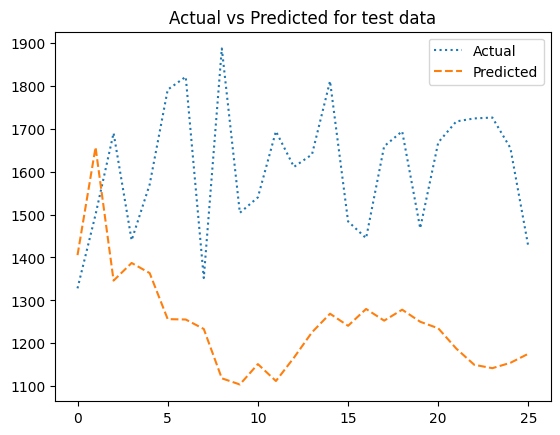

In [61]:
# calculating RMSE loss and  comparing the results
y_test_pred = np.array(y_test_pred_final)
y_test_true = np.array(cases_time_series[-test_size:])
print("The RMSE loss is: ", np.sqrt(np.mean((y_test_pred - y_test_true)**2)))
plt.plot(y_test_true, label="Actual", linestyle= "dotted")
plt.plot(y_test_pred, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted for test data")
plt.legend()
plt.show()

In [ ]:
# not doing grid search, IMF not on test ,  final.ipynb main sab hain, can erase Code.ipynb and Aryan can overwrite analysis